These are the pre-photometry steps required to align to Gaia, drizzle together and update the original image DQ extension for CR found during drizzling.

reference notebook:
https://spacetelescope.github.io/notebooks/notebooks/DrizzlePac/align_to_catalogs/align_to_catalogs.html

requirements: astroconda::drizzlepac

In [1]:
# imports
import astropy.units as u
import glob
import numpy as np
import matplotlib.pyplot as plt
import os,shutil

from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
# from astroquery.mast import Observations
# from astroquery.sdss import SDSS

from ccdproc import ImageFileCollection
from IPython.display import Image

from drizzlepac import tweakreg
from drizzlepac import astrodrizzle

Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


In [ ]:
# control what to work on

region="off"
filt="f555w"

# autoset catalog path based on user
if os.environ['USER'] =='remy':
    workdir="/Users/remy/cv/magellanic/n159/"
    
    
os.chdir(workdir+region+"/"+filt+"/")

if filt=="f125w" or filt=="f160w":
    kind="flt"
    camera="IR"
else:
    kind="flc"
    camera="UVO"

In [2]:
collec = ImageFileCollection("./", glob_include="*"+kind+".fits", ext=0,
                             keywords=["targname", "ra_targ", "dec_targ", "filter", "exptime", "postarg1", "postarg2"])

table = collec.summary
table['exptime'].format = '7.1f'
table['ra_targ'].format = '7.7f'
table['dec_targ'].format = '7.7f'
table['postarg1'].format = '7.2f'
table['postarg2'].format = '7.2f'
table

file,targname,ra_targ,dec_targ,filter,exptime,postarg1,postarg2
str18,str9,float64,float64,float64,float64,float64,float64
jcbn05a4q_flc.fits,OFF-POINT,85.2508983,-69.8056833,--,668.0,2.16,19.26
jcbn05a8q_flc.fits,OFF-POINT,85.2508983,-69.8056833,--,536.0,3.20,17.89
jcbna5abq_flc.fits,OFF-POINT,85.2508983,-69.8056833,--,650.0,0.00,0.00
jcbna5apq_flc.fits,OFF-POINT,85.2508983,-69.8056833,--,536.0,0.25,-0.50


In [ ]:
# Gaia query
RA = table['ra_targ'][0]
Dec = table['dec_targ'][0]

coord = SkyCoord(ra=RA, dec=Dec, unit=(u.deg, u.deg))
radius = Quantity(3., u.arcmin)

gaia_query = Gaia.query_object_async(coordinate=coord, radius=radius)
reduced_query = gaia_query['ra', 'dec', 'phot_g_mean_mag']
reduced_query
reduced_query.write('gaia.cat', format='ascii.commented_header')

In [ ]:
refcat = 'gaia.cat'
if camera=="UVO":
    cw = 3.5  # Set to two times the FWHM of the PSF.
    thresh=1000.
else:
    cw = 2.5
    thresh=100.
wcsname = 'Gaia'  # Specify the WCS name for this alignment
print(camera,cw)

for im in glob.glob("*"+kind+".fits"):
    if not os.path.exists(im[:-5]+".orig.fits"):
        shutil.copy(im,im[:-5]+".orig.fits")
    
tweakreg.TweakReg('*'+kind+'.fits',  # Pass input images
                  updatehdr=True,  # update header with new WCS solution
                  imagefindcfg={'threshold':thresh,'conv_width':cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  ylimit=0.2,
                  fitgeometry='general')  # Use the 6 parameter fit



In [ ]:
for line in open('Gaia_shifts.txt').readlines():
    print(line)

In [ ]:
# we have 4 exposures of ~same etime, so mosaic them all
astrodrizzle.AstroDrizzle('*'+kind+'.fits', 
                          output=filt,
                          preserve=False,
                          clean=True, 
                          build=True,
                          context=False,
                          skymethod='match',
                          driz_sep_bits='64, 32',
                          combine_type='minmed',
                          final_bits='64, 32')

UVO


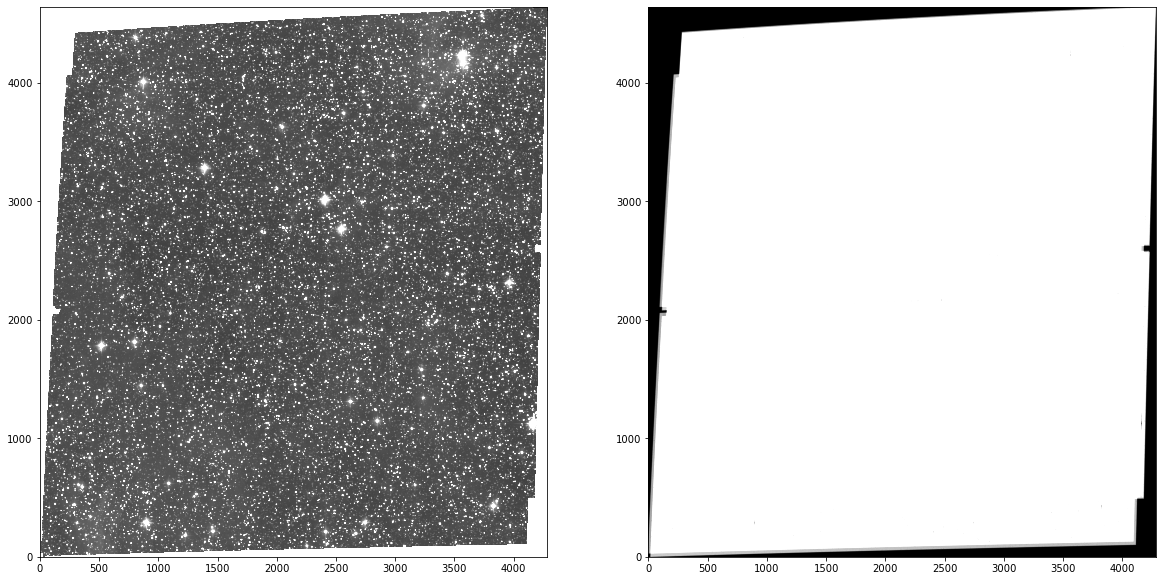

In [4]:
if camera=="UVO":
    sci = fits.getdata(filt+'_drc_sci.fits')
    wht = fits.getdata(filt+'_drc_wht.fits')
else:
    sci = fits.getdata(filt+'_drz_sci.fits')
    wht = fits.getdata(filt+'_drz_wht.fits')
print(camera)

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(sci, vmin=-0.05, vmax=0.4, cmap='Greys_r', origin='lower')
ax2.imshow(wht, vmin=0, vmax=1000, cmap='Greys_r', origin='lower')

jcbn05a4q_flc.gaiareg.fits
jcbn05a4q_flc.orig.fits


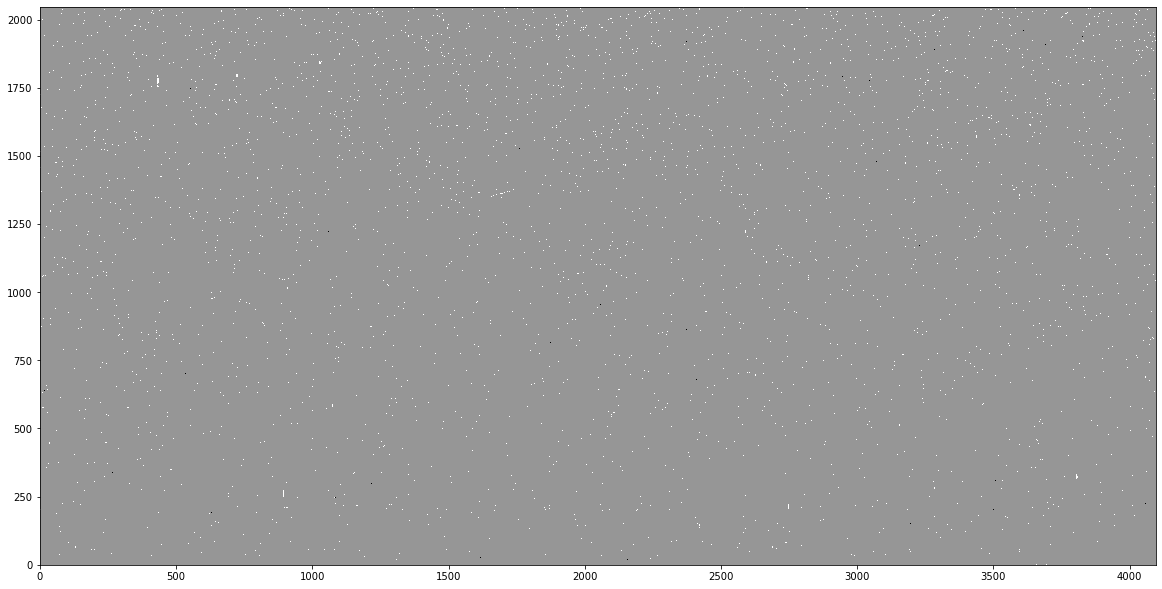

In [13]:
testim=glob.glob("*"+kind+".fits")[0]
# when this is first run, testim will have multiple extensions, and need to load X3 here
hdulist=fits.open(testim)
if len(hdulist)>3:
    print(testim)
    dq=fits.getdata(testim,3)
# however, later in the process, dolphot will have overwritten the fl[t|c] file into a single-extension file
# so we need to go get the saved "gaiareg.fits" file
else:
    print(testim[:-5]+".gaiareg.fits")
    dq=fits.getdata(testim[:-5]+".gaiareg.fits",3)

print(testim[:-5]+".orig.fits")
origdq=fits.getdata(testim[:-5]+".orig.fits",3)
fig = plt.figure(figsize=(20, 20))
#ax1 = fig.add_subplot(1, 2, 1)
#ax2 = fig.add_subplot(1, 2, 2)
ax2=fig.add_subplot(111)
#ax1.imshow(origdq, cmap='Greys_r', origin='lower')
ax2.imshow(dq-origdq, cmap='Greys_r', origin='lower',interpolation="nearest")